<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 8 - Transformers 
**Nome:** Wesley Seidel Carvalho

**Numero Usp:** 6544342













______________

# Classificação de Texto com Transformer

O objetivo deste exercício é usar o tensorflow para implementar um único bloco encoder da arquitetura Transformer, com diversas cabeças, e usar o seu resultado para classificar um texto.  Os proncipais blocos são dados, mas você derá implementar os seguintes passos:
  1. Extrair os dados de treinamento e teste do córpus
  2. Construir o embedding e a camada de posicionamento do transformer
  3. Conectar a entrada ao blco transformer e a sua saída a uma rede feed-forward.  Compilar e testar.

## Setup


In [1]:
# https://keras.io/examples/nlp/text_classification_with_transformer/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0-rc3'

## Implementa Auto-Atenção Multi-cabeça como uma camada Keras

Processamento da entrada:

  1. Para cada palavra da entrada _X_, insira num espaço de dimensão _d_;
  2. Partilha em _H_ cabeças.  Em cada cabeça multiplica _X_ com as matrizes de pesos $W_Q, W_K, W_V$;
  
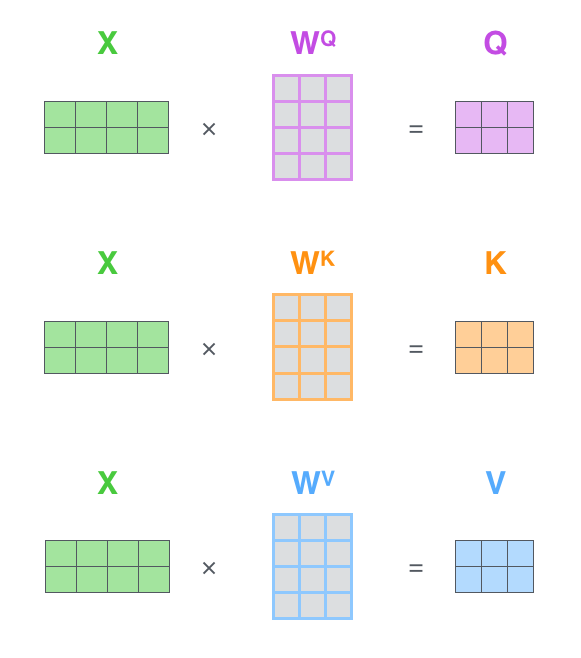

  3. Processamento de uma cabeça, calcula a atenção usando _Q,K,V_ e obtém uma matriz de saída para cada cabeça;


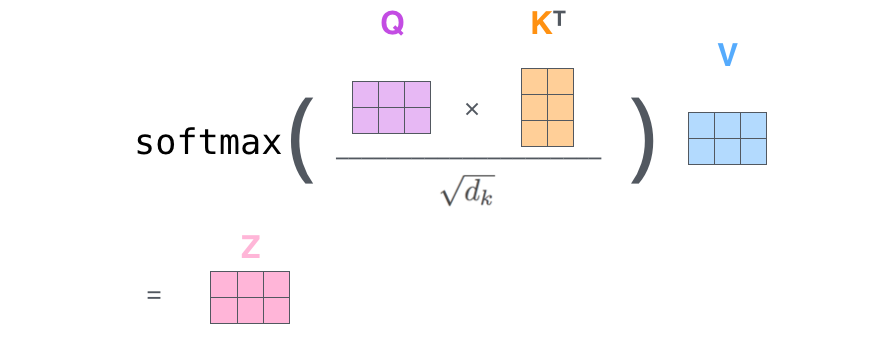

  4. Processamento multi-cabeça, concatenando as saídasem uma única matriz de saída;
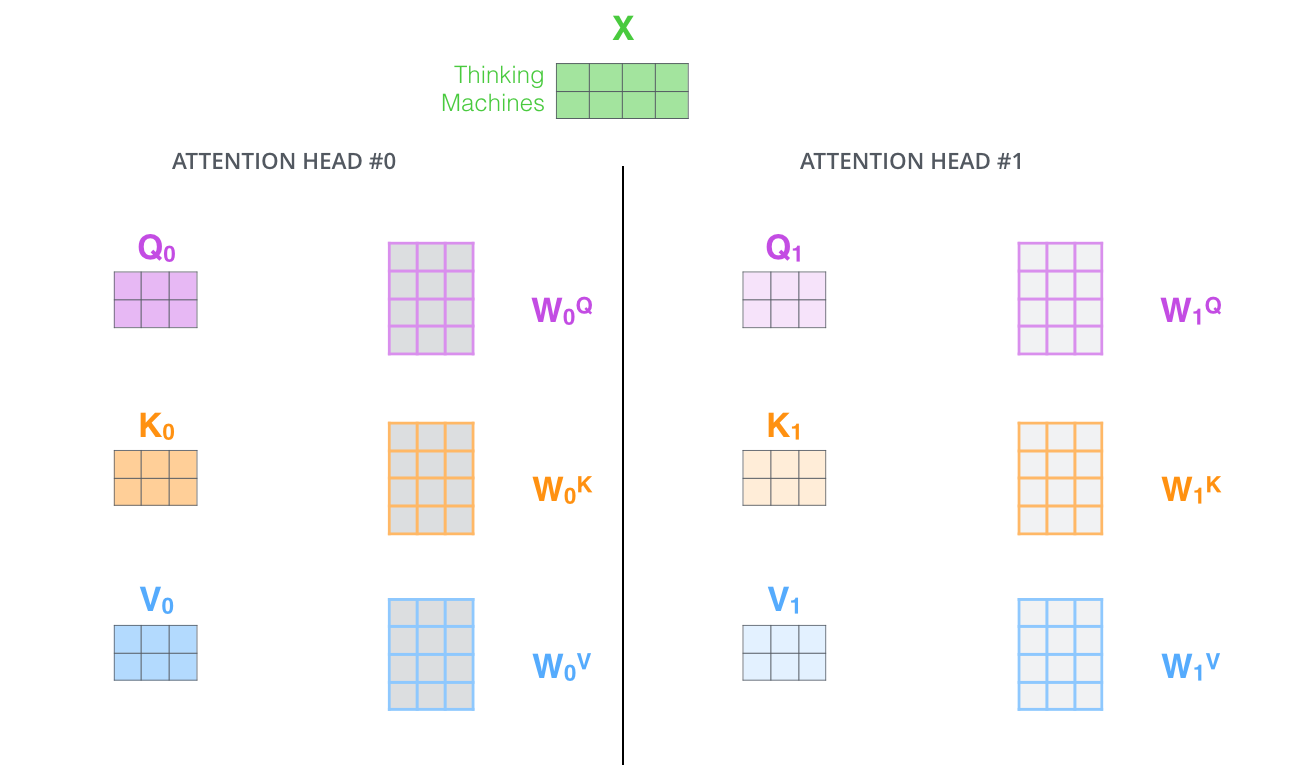



  5. Multiplica a matriz concatenada por uma matriz de pesos de saída $W^O$.

In [2]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads ):
        super(MultiHeadSelfAttention, self).__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"dimensão do embedding = {embed_dim} deve ser "  +
                "divisível pelo n. de cabeças = {num_heads}"
            )
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        # divide o embedding_dim em n_cabeças de projection_dim (batch_size e seq_len são mantidos)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # reordena o n_cabeças com a seq_len
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)      # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output



## Implementa um bloco Transformer como uma camada


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



## Implementa a camada de _embedding_ e posicionamento

## <font color='blue'>Questão 1 </font>

Aqui começa a nossa implementação.  A ideia é fazer o seguinte:

  - pegue um string $s$ e substitua cada token pelo seu _embedding_ $x_e$. Vamos novamente utilizar os vetores de palavras de 50 dimensões para lingua portuguesa fornecidos pelo NILC, como na Lista 04. Para evitar problemas de mémoria você deve utilizar apenas as 200 mil palavras mais comum. Nós ja fornecemos um script que realiza esse pré-processamento por você, basta baixar o arquivo cbow_s50.zip do site do NILC, extrai-lo na pasta deste notebook e rodar a célula seguinte. 
  - vamos calcular o posicionamento (para 50 posições) de acordo com o método **Transformer**.  Existem algumas formas de fazer isso
      * Criar uma camada específica para codificar o posicionamento.  Esta camada recebe na entrada o número da posição  e retorna um vetor de tamanho embedding_dim (50 para nós), e deve ser treinada junto co o resto.
      * Usar o método de posicionamento dos Transformes. **É isso que vocês irão fazer !!!** a forma de computar esses valores é:
      
      $$PE[pos, i] = sin \left(\frac{pos}{10000^{i/d}}\right), ~~~~~i \textrm{ é par}$$
      
      $$PE[pos, i] = cos \left(\frac{pos}{10000^{(i-1)/d}} \right),   ~~~~i \textrm{ é ímpar}$$
      
onde $pos$ é a posição, $i$ é a dimensãoe $d$ é a dimensão do embedding (50, no nosso caso).  Sinta-se a vontade para alterar esta fórmula!

  - **Some** o embedding com o posicionamento

### Configurações e variáveis para rodar o projeto:

In [4]:
# Definindo as variáveis do projeto
vocab_size = 200000  # Considerar 200k palavras
maxlen = 200  # Considerar apenas as 100 primeiras palavras do texto da review

embed_dim = 50 # tamanho do Embedding de cada token ( também do word2vec da NILC)
num_heads = 2  # N. de cabeças de atenção
ff_dim = 32   # tamanho da camada oculta nas redes feed forward dentro do transformer


# Path para o arquivo de dados da b2w
# B2W_DATAFILE = "../../data/b2w-10k.csv" (O meu b2w-10k está separado por virgulas)
B2W_DATAFILE = "../../data/B2W-Reviews01.csv"

# Path para o arquivo de dados de embeddings do NILC
NILC_W2V_DATAFILE = "word2vec_200k.txt"

# Quantidade de epocas para o treino
QNT_EPOCAS_A_TREINAR = 10  # 2

### Comentários:
Para o cálculo do Positional Embedding
Testei diversas formas e consultei bastante material.
O que funcionou e "consegui entender" foi o exemplo obtido no tutorial do próprio TensorFlow:

 - a) https://www.tensorflow.org/tutorials/text/transformer


Além do link citado acima, também consultei diversas outras fontes, principalmente:

 - b) https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb
 - c) https://jalammar.github.io/illustrated-transformer/
 - d) https://keras.io/examples/nlp/text_classification_with_transformer/
 - e) https://stackoverflow.com/questions/61550968/implementation-details-of-positional-encoding-in-transformer-model

In [5]:
import numpy as np

# Funções para auxiliar na criação da camanda de PE
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

# pos_encoding = positional_encoding(50, 200)
# pos_encoding

In [6]:
# Carregar o Word2Vec do NILC
from gensim.models import KeyedVectors
model_w2v = KeyedVectors.load_word2vec_format(NILC_W2V_DATAFILE)

In [7]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = positional_encoding(maxlen, embed_dim)
        self.token_emb = model_w2v.get_keras_embedding()

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = self.pos_emb[:, :maxlen, :]
        x = self.token_emb(x)
        return x + positions

## Prepare o dataset

## <font color='blue'>Questão 2 </font>

   Vamos usar o dataset da B2W, como entrada teremos o campo `review_text` e como saída (o que queremos prever) é 0 campo `recommend_to_a_friend`, com "yes" -> 1 e "no" -> 0.
   
   V deve dividir os dados com 80% treino e 20% teste.  Dê uma embaralhada aleatória nos dados para, se você quiser, fazer validação cruzada ($k$-fold).


In [8]:
# Meus codigos...
# Carregando o  B2W
import pandas as pd
from sklearn.model_selection import train_test_split

# b2wCorpus = pd.read_csv(B2W_DATAFILE)
b2wCorpus = pd.read_csv(B2W_DATAFILE, sep=';', usecols=["review_text", "recommend_to_a_friend"])

def sentence_to_nilc_index_token(text, stem=False):
    # Traduzindo os tokens do B2W para o index do NILC
    tokens = text.lower().split() # Pegar um tokenizer decente...
    tokens = [model_w2v.vocab[t].index if t in model_w2v.vocab else 1 for t in tokens ]
    return tokens


df = b2wCorpus[['review_text','recommend_to_a_friend']]
df = df.assign(recommend_to_a_friend_new=0)
# df['recommend_to_a_friend_new'] = df.recommend_to_a_friend.map({'Yes': 1, 'No': 0}) 
# df['recommend_to_a_friend_new']  = df['recommend_to_a_friend_new'].astype(int)
df['recommend_to_a_friend_new'] = df.recommend_to_a_friend.apply(lambda word : 1 if word == 'Yes' else 0)
df = df.dropna()

# Aplicando o sentence_to_nilc_index_token
df['review_text_clean'] = b2wCorpus.review_text.apply(lambda x: sentence_to_nilc_index_token(x))

# df[['review_text', 'review_text_clean', 'recommend_to_a_friend', 'recommend_to_a_friend_new']]

In [9]:
# df.groupby(['recommend_to_a_friend_new']).count()

In [10]:
# Separando os dados em Treino e Teste utilizando a proporção 80% treino e 20% teste.
                                            
x_train, x_test, y_train, y_test = train_test_split(df['review_text_clean'], df['recommend_to_a_friend_new'], test_size=0.20, random_state=17)

# Aplicando o Padding ao x_train, x_test utilizando o padding post para alinhar à esquerda.
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')

# Observando:
# print("Tamanho do VETOR DE PALAVRAS DO TEXTO 1:", len(x_train[1]) )
# print("O vetor representativo do texto 1 apos o padding:" )
# print(x_train[1])

## Crie um classificador usando o bloco transformer

## <font color='blue'>Questão 3 </font>

A camada do transformer produz um vetor para cada palavra da sequência de entrada.  Aqui você tem duas possibilidades e vai ter de escolher:
  - Pegar a média em todas as saídas e usar uma rede de feed forward sobre ela para classificar o texto.
  - Inserir uma mesma palavra <start> no início de todas as sentenças, com embedding comomo de qualquer outra palavra.   Usar uma rede de feed forward sobre a saída desta palavra <start>  para classificar o texto.  

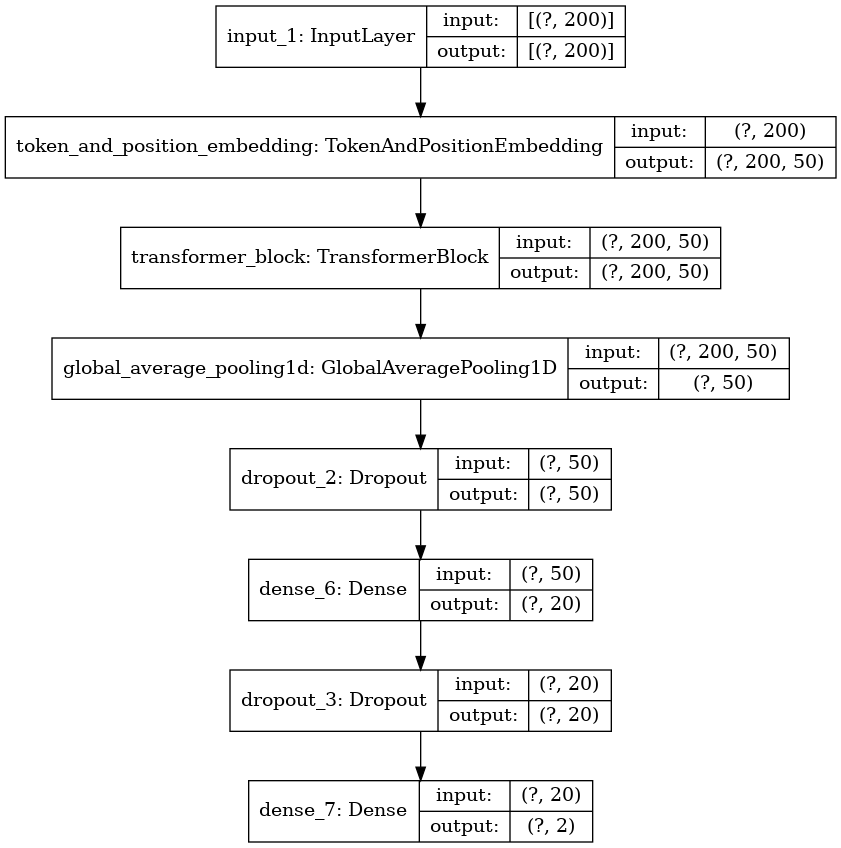

In [11]:
# complete 0 código abaixo
# Movi as variaveis do modelo para uma célula na 1a questão.

# Trecho de código extraido de 
# https://keras.io/examples/nlp/text_classification_with_transformer/#create-classifier-model-using-transformer-layer
#
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# Pegando a média de todas as saídas.
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Desenhando a representação gráfica do modelo final
keras.utils.plot_model(model, "model_text_classificarion_with_transformer.png", show_shapes=True)

## Treine e Teste

(Pode mudar, se quiser)

In [12]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=QNT_EPOCAS_A_TREINAR, validation_data=(x_test, y_test)
)

Epoch 1/10
3309/3309 [==============================] - 322s 97ms/step - loss: 0.4725 - accuracy: 0.7748 - val_loss: 0.3816 - val_accuracy: 0.8283
Epoch 2/10
3309/3309 [==============================] - 320s 97ms/step - loss: 0.3739 - accuracy: 0.8336 - val_loss: 0.3459 - val_accuracy: 0.8494
Epoch 3/10
3309/3309 [==============================] - 303s 92ms/step - loss: 0.3520 - accuracy: 0.8466 - val_loss: 0.3419 - val_accuracy: 0.8541
Epoch 4/10
3309/3309 [==============================] - 300s 91ms/step - loss: 0.3426 - accuracy: 0.8508 - val_loss: 0.3274 - val_accuracy: 0.8581
Epoch 5/10
3309/3309 [==============================] - 331s 100ms/step - loss: 0.3353 - accuracy: 0.8555 - val_loss: 0.3241 - val_accuracy: 0.8623
Epoch 6/10
3309/3309 [==============================] - 299s 90ms/step - loss: 0.3296 - accuracy: 0.8582 - val_loss: 0.3198 - val_accuracy: 0.8646
Epoch 7/10
3309/3309 [==============================] - 301s 91ms/step - loss: 0.3245 - accuracy: 0.8619 - val_loss: 